            t          S      price   price_mc     delta     theta
0    0.139652  51.688843   3.536290   3.449160  0.671777 -5.274241
1    0.234652  65.022176  15.353651  15.388237  0.998876 -2.049758
2    0.044652  33.911065   0.003413   0.001232  0.002662 -0.054872
3    0.282152  47.244399   0.533554   0.527163  0.257707 -5.353600
4    0.092152  60.577732  11.319829  11.256986  0.958547 -2.935218
..        ...        ...        ...        ...       ...       ...
445  0.400000  52.222222   2.222222   2.222222  1.000000  0.000000
446  0.400000  56.666667   6.666667   6.666667  1.000000  0.000000
447  0.400000  61.111111  11.111111  11.111111  1.000000  0.000000
448  0.400000  65.555556  15.555556  15.555556  1.000000  0.000000
449  0.400000  70.000000  20.000000  20.000000  1.000000  0.000000

[450 rows x 6 columns]


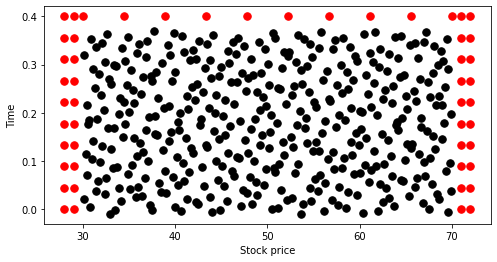

In [1]:
#Generating Black-Scholes training and test data

from BS_data import call_data, call_data_halton

virtual_points = True #choose whether you want additional virtual training points on the edges of the grid

# space_frame, test_frame = call_data(virtual_points) #equally spaced training grid
space_frame, test_frame = call_data_halton(virtual_points) #randomly spaced training grid
print(space_frame) #training data
# print(test_frame) #test data

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(space_frame['S'][0:-50], space_frame['t'][0:-50], color = 'black', s = 56)
plt.scatter(space_frame['S'][-50:], space_frame['t'][-50:], color = 'r', s = 56)
plt.xlabel("Stock price")
plt.ylabel("Time")
plt.show()

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow_probability.python.math.psd_kernels.internal import util
import custom_kernels #here we define custom kernels, as described in the paper by Ludkovski and Saporito

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [3]:
### GP model + training

#trained variables
amplitude = 239.71
l1 = 0.626
l2 = 10.
#TransformedVariable ensures positivity
#clip_by_value sets boundaries on the possible values of the trainable variable
amplitude = tfp.util.TransformedVariable(amplitude, tfb.Exp(), dtype=tf.float64, name='amplitude', \
                                         constraint=lambda t: tf.clip_by_value(t, np.log(1.), np.log(800.0)))
length_scale = tfp.util.TransformedVariable([l1, l2], tfb.Exp(), dtype=tf.float64, name='length_scale', \
                                           constraint=lambda t: tf.clip_by_value(t, [np.log(0.1), np.log(1.)],\
                                                                                 [np.log(2.), np.log(50.)]))
observation_noise_variance = tfp.util.TransformedVariable(1.99e-4, tfb.Exp(), dtype=tf.float64, name='observation_noise_variance')
beta_0 = tf.Variable(-20.04, dtype=tf.float64, name='beta_0')
beta_1 = tf.Variable(0.58, dtype=tf.float64, name='beta_1')


kernel = custom_kernels.M52_custom(amplitude = amplitude,length_scale = length_scale) #Custom Matern 5/2 kernel
#kernel = custom_kernels.SE_custom(amplitude = amplitude, length_scale = length_scale) #Custom RBF kernel
mean_fn = lambda x: beta_0 + beta_1*x[:,1]


training_points = np.array(list(zip(space_frame['t'],space_frame['S'])))
observed_values = space_frame['price']

#defining the GP
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=training_points,
    mean_fn=mean_fn,
    observation_noise_variance= observation_noise_variance)


#Training the GP
optimizer = tf.optimizers.Adam(learning_rate = 0.1)

@tf.function
def optimize():
    with tf.GradientTape() as tape:
        tape.watch([beta_0, beta_1])
        loss = -gp.log_prob(observed_values)
    var_to_be_trained = gp.trainable_variables + (beta_0,beta_1,)
    grads = tape.gradient(loss, var_to_be_trained)
    optimizer.apply_gradients(zip(grads, var_to_be_trained))
    return loss

for i in range(300):
    neg_log_likelihood = optimize()
    if i % 100 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood))
print("Final NLL = {}".format(neg_log_likelihood))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Step 0: NLL = -879.4597478514402
Step 100: NLL = -1635.6108739648978
Step 200: NLL = -1641.5293856260491
Final NLL = -1642.6825895927402


In [4]:
#Final values of the trained hyperparameters

print('amplitude: ', amplitude.numpy())
print('b0: ', beta_0.numpy())
print('b1: ', beta_1.numpy())
print('length scale: ', length_scale.numpy())
print('sigma_epsilon: ', observation_noise_variance.numpy())

amplitude:  2.0074046691954313
b0:  -16.650217897792945
b1:  0.5090298927549617
length scale:  [ 0.39702334 10.35109454]
sigma_epsilon:  1.2341631379680754e-07


In [5]:
### Analytic computation of confidence intervals
import analytic_variance

t = test_frame['t']
S = test_frame['S']
x_rand = tf.Variable(np.array(list(zip(t,S)))) #test data
theta_delta = 1 #choose 0 for theta; 1 for delta

#analytic posterior variance of call price
var_star = tf.linalg.diag_part(analytic_variance.K_analytic(gp, x_rand, training_points)) 

#analytic posterior variance of delta or theta
V_g = analytic_variance.V_g_analytic(gp, x_rand, training_points, 'M52', theta_delta) #change M52 or SE depending on kernel choice
print('V_g', V_g)

V_g tf.Tensor(
[2.27499443e-05 3.37090525e-06 3.50222722e-06 2.34141524e-06
 3.19017054e-06 3.07777214e-06 3.25285969e-06 4.22315969e-06
 3.39965444e-06 2.97223500e-06 3.21889035e-06 2.95563421e-06
 2.75942230e-06 2.75023950e-06 2.75378137e-06 2.72803502e-06
 3.14796259e-06 3.39784149e-06 3.40710954e-06 3.13766692e-06
 3.64037381e-06 2.81420660e-06 2.95290304e-06 3.11762221e-06
 2.92317806e-06 2.31414117e-06 3.35109318e-06 4.05604626e-06
 2.32102247e-06 1.78388290e-05], shape=(30,), dtype=float64)


In [6]:
### Computing derivatives with GradientTape

test_x = tf.constant(np.array(list(zip(test_frame['t'],test_frame['S']))))
test_y = test_frame['price']
true_y = test_frame['delta']

#gprm defines the posterior distribution of the call price
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=test_x,
    mean_fn=mean_fn,
    observation_index_points=training_points,
    observations=observed_values,
    observation_noise_variance= observation_noise_variance)

#computes the posterior call price (m_star), its std deviation (std_star), and the posterior Greeks (g)
def greek():
    with tf.GradientTape() as tape:
        tape.watch(test_x)
        m_star = gprm.mean()
        std_star = gprm.stddev()
    g = tape.gradient(m_star, test_x)
    
    return m_star, std_star, g

#computes the posterior covariance matrix of the chosen Greek
def double_gradient_k_star(x, y):   
    with tf.GradientTape() as tape2:
        tape2.watch(y)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            K_star = gprm.kernel.apply(x,y)
        dK_star = tape1.gradient(K_star, x)[:,theta_delta]
    d2K_star = tape2.gradient(dK_star, y)[:,theta_delta]
    return K_star, d2K_star
    
#computes a distance between the true Greek and the estimated Greek
def RIMSE(y, y_true):
    return tf.sqrt(tf.reduce_mean((y - y_true)**2))


prior_k, posterior_k = double_gradient_k_star(test_x, test_x+gprm.jitter**2)

#the two variance vectors should be the same
print('computational_Vg: ', posterior_k) #variance of the Greek computed with GradientTape
print('analytical_Vg: ', V_g) #variance of the Greek computed with analytical formulae

m_star, std_star, g = greek()
m_star = np.squeeze(m_star)
std_star= np.squeeze(std_star)
theta = g[:,0]
delta = g[:,1]

RMS = RIMSE(delta, true_y)
print('RMS: ', RMS)


computational_Vg:  tf.Tensor(
[2.61537696e-05 6.09732375e-06 6.62357538e-06 5.29058022e-06
 6.90022515e-06 5.99752185e-06 6.31626483e-06 7.31827819e-06
 6.33140962e-06 6.21035226e-06 6.35517616e-06 6.13578267e-06
 5.65639929e-06 6.15251623e-06 6.04702807e-06 5.47030890e-06
 6.10680252e-06 6.28628915e-06 6.01659421e-06 6.56288776e-06
 7.04128251e-06 5.98990163e-06 5.81246167e-06 6.19159839e-06
 5.64013666e-06 5.67055701e-06 6.81530065e-06 6.92198295e-06
 5.16330472e-06 2.34146669e-05], shape=(30,), dtype=float64)
analytical_Vg:  tf.Tensor(
[2.27499443e-05 3.37090525e-06 3.50222722e-06 2.34141524e-06
 3.19017054e-06 3.07777214e-06 3.25285969e-06 4.22315969e-06
 3.39965444e-06 2.97223500e-06 3.21889035e-06 2.95563421e-06
 2.75942230e-06 2.75023950e-06 2.75378137e-06 2.72803502e-06
 3.14796259e-06 3.39784149e-06 3.40710954e-06 3.13766692e-06
 3.64037381e-06 2.81420660e-06 2.95290304e-06 3.11762221e-06
 2.92317806e-06 2.31414117e-06 3.35109318e-06 4.05604626e-06
 2.32102247e-06 1.78388290e-

In [7]:
#Define conventions for figure sizes

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

mse:  2.3816198970949197e-07


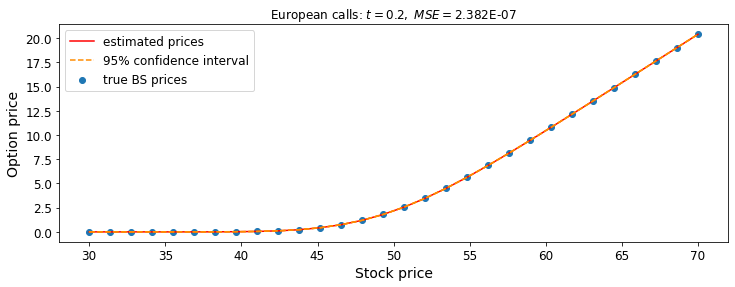

In [8]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(m_star, test_y)
print('mse: ', mse) #Mean squared error between estimated call price and true call price

# Plot the call price
plt.figure(figsize=(12,4))
plt.scatter(test_x[:,1], test_y, label='true BS prices')
plt.plot(test_x[:,1], m_star, c='r', alpha=1, label='estimated prices')
plt.plot(test_x[:,1], m_star-1.96*std_star, c='darkorange', alpha=1, linestyle='dashed', label='95% confidence interval')
plt.plot(test_x[:,1], m_star+1.96*std_star, c='darkorange', alpha=1, linestyle='dashed')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Stock price")
plt.ylabel("Option price")
plt.title(r'European calls: $t = 0.2, \ MSE = $' + str("{:.3E}".format(mse)))
plt.show()

mse:  2.018511209574687e-06


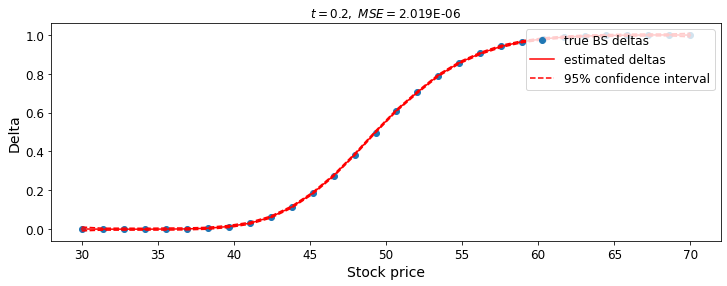

In [9]:
mse = mean_squared_error(delta, true_y)
print('mse: ', mse) #Mean squared error between estimated Delta and true Delta

# Plot delta
plt.figure(figsize=(12, 4))
plt.plot(test_x[:,1], true_y, label='true BS deltas', linestyle=' ', marker='o', linewidth = 5.)
plt.plot(test_x[:,1], delta, c='r', alpha = 1, label='estimated deltas')
plt.plot(test_x[:,1], delta - 1.96*np.sqrt(posterior_k), c='r', alpha=1, linestyle='dashed', label='95% confidence interval')
plt.plot(test_x[:,1], delta + 1.96*np.sqrt(posterior_k), c='r', alpha=1, linestyle='dashed')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("Stock price")
plt.ylabel("Delta")
plt.title(r'$t = 0.2, \ MSE = $' + str("{:.3E}".format(mse)))
plt.show()